# Text Classification Using Bi-LSTM, LSTM, and GRU

1. Loading the Data and Preprocessing

In [53]:
import json
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

with open(r"C:\Users\kjson\Downloads\sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

# original 10000
vocab_size = 10000
# 16 original
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
total_size = len(sentences)
training_ratio = 0.8  # Set the training ratio

# Split the data into training and testing sets
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(
    sentences, labels, test_size=1 - training_ratio, random_state=42
)

# Convert sentences to sequences and pad them
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)


2. Building Bi-LSTM Architecture

In [33]:
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

bilstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

# Adjusting the learning rate
learning_rate = 0.00005 

optimizer = RMSprop(learning_rate=learning_rate)

bilstm_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
bilstm_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               12544     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 24)                1560      
                                                                 
 dropout_14 (Dropout)        (None, 24)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
________________________________________________

3. Training and Testing Bi-LSTM Model

In [34]:
# Setting up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
num_epochs = 1000
bilstm_history = bilstm_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[early_stop])


Epoch 1/1000
668/668 - 30s - loss: 0.9984 - accuracy: 0.5607 - val_loss: 0.9390 - val_accuracy: 0.5608 - 30s/epoch - 45ms/step
Epoch 2/1000
668/668 - 28s - loss: 0.8915 - accuracy: 0.5611 - val_loss: 0.8480 - val_accuracy: 0.5608 - 28s/epoch - 42ms/step
Epoch 3/1000
668/668 - 28s - loss: 0.8142 - accuracy: 0.5611 - val_loss: 0.7830 - val_accuracy: 0.5608 - 28s/epoch - 42ms/step
Epoch 4/1000
668/668 - 30s - loss: 0.7595 - accuracy: 0.5611 - val_loss: 0.7380 - val_accuracy: 0.5608 - 30s/epoch - 44ms/step
Epoch 5/1000
668/668 - 31s - loss: 0.7219 - accuracy: 0.5619 - val_loss: 0.7061 - val_accuracy: 0.5608 - 31s/epoch - 46ms/step
Epoch 6/1000
668/668 - 30s - loss: 0.6915 - accuracy: 0.5765 - val_loss: 0.6752 - val_accuracy: 0.5990 - 30s/epoch - 46ms/step
Epoch 7/1000
668/668 - 30s - loss: 0.6593 - accuracy: 0.6333 - val_loss: 0.6407 - val_accuracy: 0.6357 - 30s/epoch - 45ms/step
Epoch 8/1000
668/668 - 30s - loss: 0.6283 - accuracy: 0.6953 - val_loss: 0.6105 - val_accuracy: 0.7606 - 30s/ep

4. Plotting Accuracy and Loss of Bi-LSTM Model

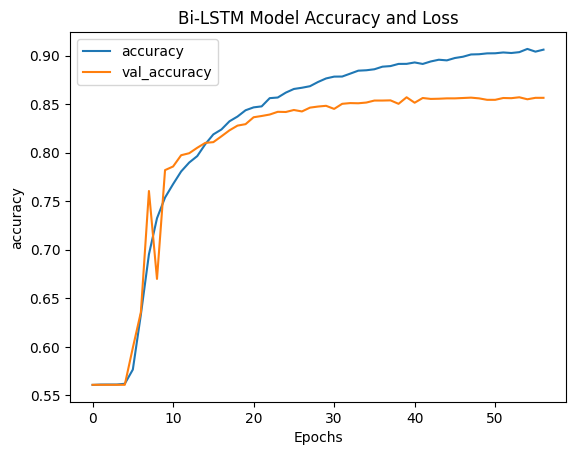

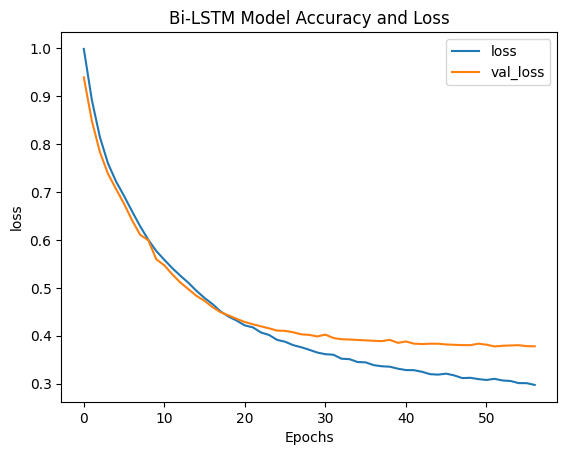

167/167 [==============================] - 2s 13ms/step - loss: 0.3779 - accuracy: 0.8566
Bi-LSTM Model Accuracy: 85.66%


In [50]:
# Plotting accuracy and loss of Bi-LSTM Model
def plot_graphs(bilstm_history, string):
  plt.plot(bilstm_history.history[string])
  plt.plot(bilstm_history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('Bi-LSTM Model Accuracy and Loss') 
  plt.show()

plot_graphs(bilstm_history, 'accuracy')
plot_graphs(bilstm_history, 'loss')

bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(testing_padded, testing_labels)
print("Bi-LSTM Model Accuracy: {:.2f}%".format(bilstm_accuracy * 100))


5. Building LSTM Model Architecture

In [54]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

# Defining the LSTM model with regularizers
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

# Adjusting the learning rate
learning_rate = 0.01  

optimizer = RMSprop(learning_rate=learning_rate)

lstm_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 16)           160000    
                                                                 
 lstm_14 (LSTM)              (None, 32)                6272      
                                                                 
 dense_26 (Dense)            (None, 24)                792       
                                                                 
 dropout_19 (Dropout)        (None, 24)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 25        
                                                                 
Total params: 167,089
Trainable params: 167,089
Non-trainable params: 0
_________________________________________________________________


6. Training and Testing LSTM Model

In [55]:
# Setting up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
num_epochs = 1000
lstm_history = lstm_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[early_stop])


Epoch 1/1000
668/668 - 22s - loss: 0.6895 - accuracy: 0.5603 - val_loss: 0.6859 - val_accuracy: 0.5608 - 22s/epoch - 33ms/step
Epoch 2/1000
668/668 - 20s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6859 - val_accuracy: 0.5608 - 20s/epoch - 30ms/step
Epoch 3/1000
668/668 - 20s - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6860 - val_accuracy: 0.5608 - 20s/epoch - 31ms/step
Epoch 4/1000
668/668 - 20s - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6857 - val_accuracy: 0.5608 - 20s/epoch - 31ms/step
Epoch 5/1000
668/668 - 21s - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6858 - val_accuracy: 0.5608 - 21s/epoch - 31ms/step
Epoch 6/1000
668/668 - 23s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6859 - val_accuracy: 0.5608 - 23s/epoch - 34ms/step
Epoch 7/1000
668/668 - 22s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6859 - val_accuracy: 0.5608 - 22s/epoch - 33ms/step
Epoch 8/1000
668/668 - 25s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6858 - val_accuracy: 0.5608 - 25s/ep

7. Plotting accuracy and loss of LSTM Model

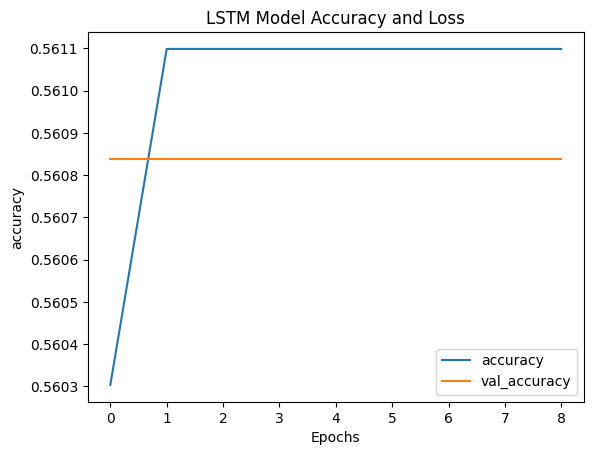

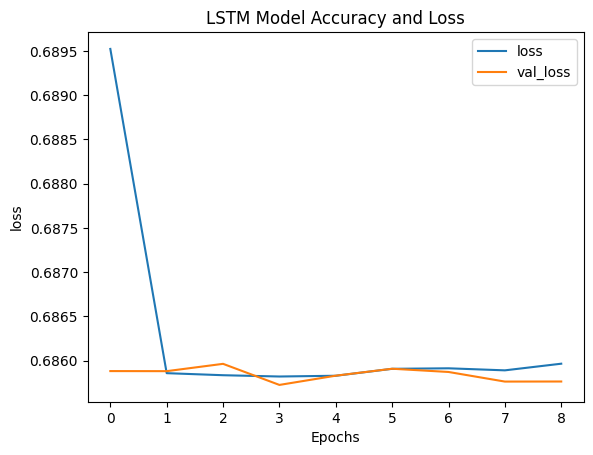

167/167 [==============================] - 2s 11ms/step - loss: 0.6858 - accuracy: 0.5608
LSTM Model Accuracy: 56.08%


In [70]:
# Plotting accuracy and loss of LSTM Model
def plot_graphs(lstm_history, string):
  plt.plot(lstm_history.history[string])
  plt.plot(lstm_history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('LSTM Model Accuracy and Loss') 
  plt.show()

plot_graphs(lstm_history, 'accuracy')
plot_graphs(lstm_history, 'loss')

lstm_loss, lstm_accuracy = lstm_model.evaluate(testing_padded, testing_labels)
print("LSTM Model Accuracy: {:.2f}%".format(lstm_accuracy * 100))

8. Building GRU Model Architecture

In [43]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import RMSprop

# Defining the GRU model with regularizers
gru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(32),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

# Adjusting the learning rate
learning_rate = 0.01 

optimizer = RMSprop(learning_rate=learning_rate)

gru_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gru_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 16)           160000    
                                                                 
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dense_24 (Dense)            (None, 24)                792       
                                                                 
 dropout_18 (Dropout)        (None, 24)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 25        
                                                                 
Total params: 165,617
Trainable params: 165,617
Non-trainable params: 0
_________________________________________________________________


9. Training and Testing GRU Model

In [44]:
# Setting up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
num_epochs = 1000
gru_history = gru_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[early_stop])


Epoch 1/1000
668/668 - 22s - loss: 0.6892 - accuracy: 0.5604 - val_loss: 0.6858 - val_accuracy: 0.5608 - 22s/epoch - 34ms/step
Epoch 2/1000
668/668 - 21s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6857 - val_accuracy: 0.5608 - 21s/epoch - 32ms/step
Epoch 3/1000
668/668 - 21s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6857 - val_accuracy: 0.5608 - 21s/epoch - 32ms/step
Epoch 4/1000
668/668 - 22s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6859 - val_accuracy: 0.5608 - 22s/epoch - 33ms/step
Epoch 5/1000
668/668 - 24s - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6857 - val_accuracy: 0.5608 - 24s/epoch - 35ms/step
Epoch 6/1000
668/668 - 24s - loss: 0.6860 - accuracy: 0.5611 - val_loss: 0.6861 - val_accuracy: 0.5608 - 24s/epoch - 35ms/step
Epoch 7/1000
668/668 - 23s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6860 - val_accuracy: 0.5608 - 23s/epoch - 35ms/step
Epoch 8/1000
668/668 - 24s - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6862 - val_accuracy: 0.5608 - 24s/ep

10. Plotting accuracy and loss of GRU Model

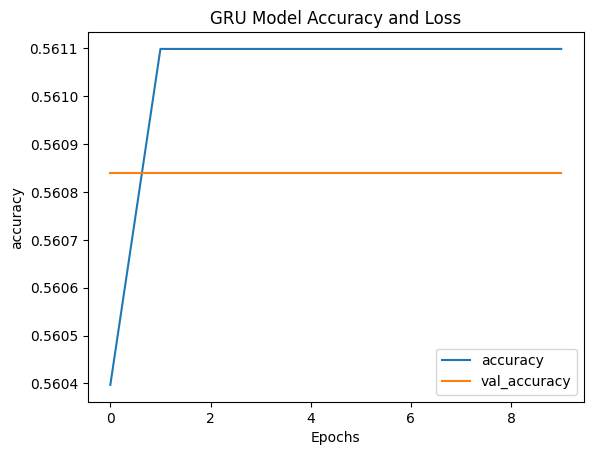

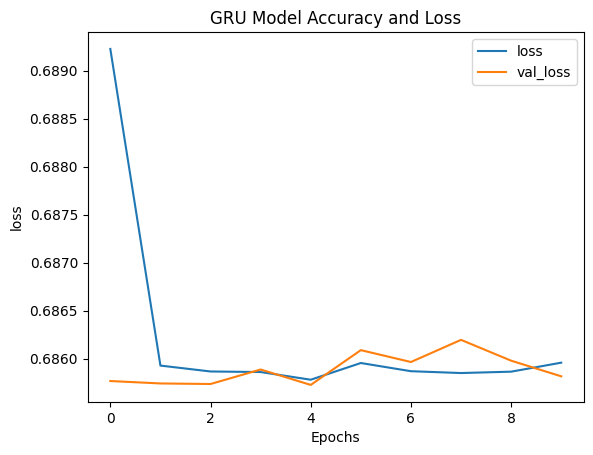

167/167 [==============================] - 2s 9ms/step - loss: 0.6858 - accuracy: 0.5608
LSTM Model Accuracy: 56.08%


In [75]:
# Plotting accuracy and loss of GRU Model
def plot_graphs(gru_history, string):
  plt.plot(gru_history.history[string])
  plt.plot(gru_history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('GRU Model Accuracy and Loss') 
  plt.show()

plot_graphs(gru_history, 'accuracy')
plot_graphs(gru_history, 'loss')

gru_loss, gru_accuracy = gru_model.evaluate(testing_padded, testing_labels)
print("LSTM Model Accuracy: {:.2f}%".format(gru_accuracy * 100))

11. Predicting if Sentence is Sarcastice or Not Using The Models

In [65]:
e = bilstm_model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night",
            "safety meeting ends in accident",
            "Miracle Cure kills fifth patient",
            "A good heart is colour-blind",
            "Foreign workers drag down UK wages",
            ]
            

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

bilstm_prediction = bilstm_model.predict(padded)
lstm_prediction = lstm_model.predict(padded)
gru_prediction = gru_model.predict(padded)

print("Bi-LSTM Predictions:")
for i, pred in enumerate(bilstm_prediction):
    print(f"Sentence: {sentence[i]}")
    print("Prediction:", pred)

print("\nLSTM Predictions:")
for i, pred in enumerate(lstm_prediction):
    print(f"Sentence: {sentence[i]}")
    print("Prediction:", pred)

print("\nGRU Predictions:")
for i, pred in enumerate(gru_prediction):
    print(f"Sentence: {sentence[i]}")
    print("Prediction:", pred)


(10000, 16)
1/1 [==============================] - 0s 31ms/step
Bi-LSTM Predictions:
Sentence: granny starting to fear spiders in the garden might be real
Prediction: [0.4711192]
Sentence: game of thrones season finale showing this sunday night
Prediction: [0.34225884]
Sentence: safety meeting ends in accident
Prediction: [0.78242767]
Sentence: Miracle Cure kills fifth patient
Prediction: [0.77194715]
Sentence: A good heart is colour-blind
Prediction: [0.05355847]
Sentence: Foreign workers drag down UK wages
Prediction: [0.05934059]

LSTM Predictions:
Sentence: granny starting to fear spiders in the garden might be real
Prediction: [0.44356638]
Sentence: game of thrones season finale showing this sunday night
Prediction: [0.44356638]
Sentence: safety meeting ends in accident
Prediction: [0.44356638]
Sentence: Miracle Cure kills fifth patient
Prediction: [0.44356638]
Sentence: A good heart is colour-blind
Prediction: [0.44356638]
Sentence: Foreign workers drag down UK wages
Prediction: 

Plotting the Graphs Side by Side

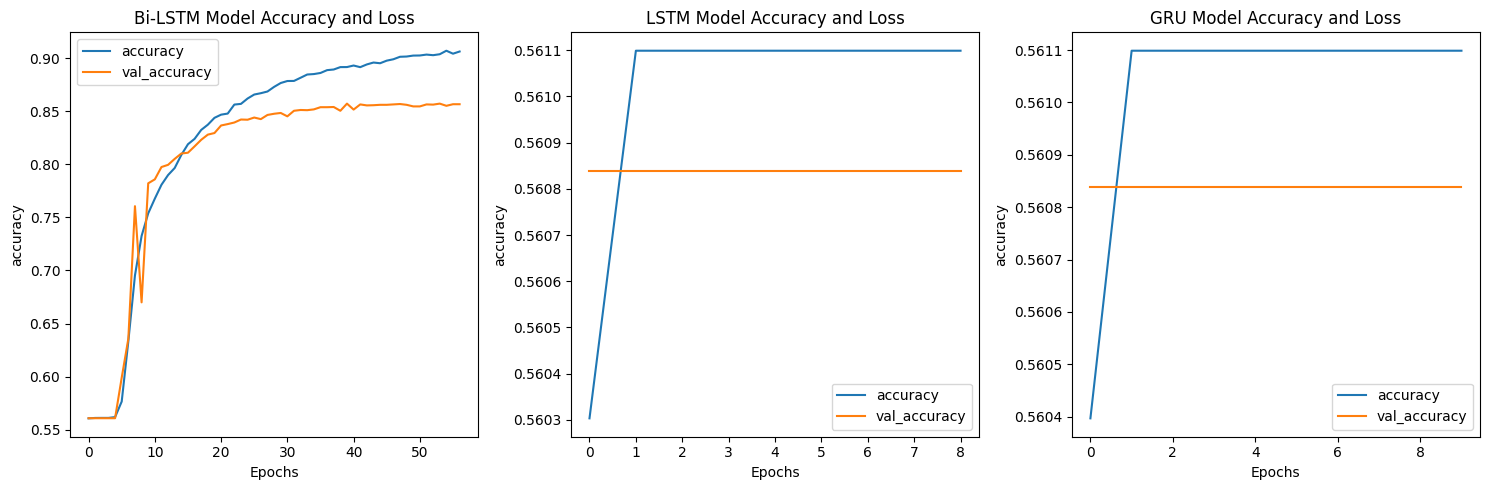

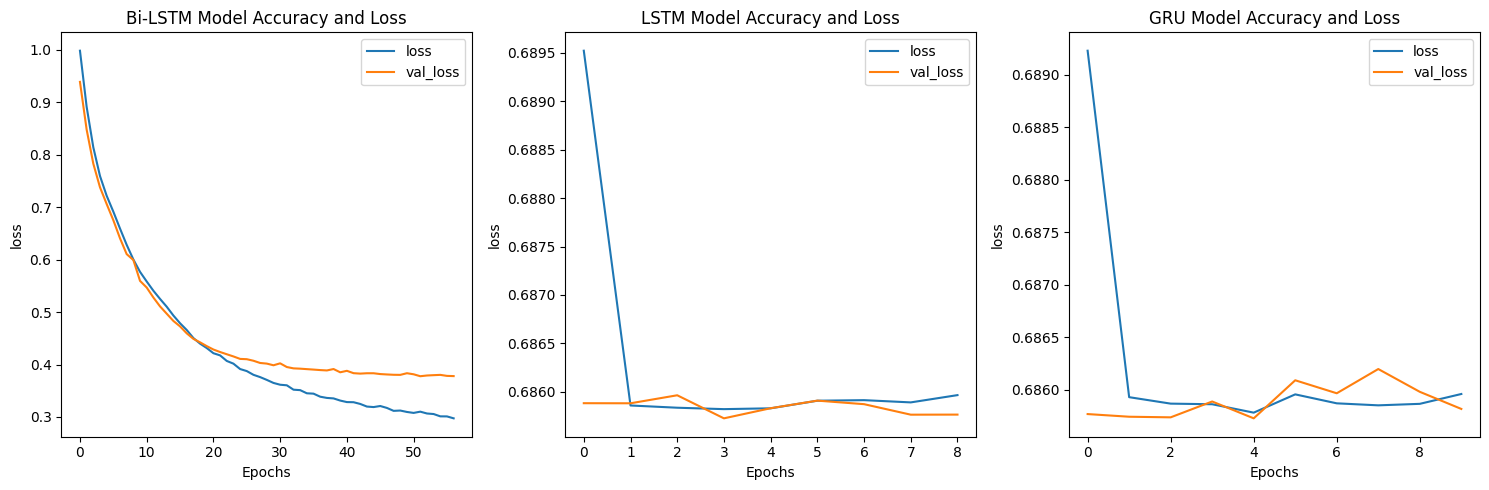

In [69]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss of Bi-LSTM Model
def plot_graphs(bilstm_history, lstm_history, gru_history, string):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(bilstm_history.history[string])
    axes[0].plot(bilstm_history.history['val_' + string])
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(string)
    axes[0].legend([string, 'val_' + string])
    axes[0].set_title('Bi-LSTM Model Accuracy and Loss')

    axes[1].plot(lstm_history.history[string])
    axes[1].plot(lstm_history.history['val_' + string])
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(string)
    axes[1].legend([string, 'val_' + string])
    axes[1].set_title('LSTM Model Accuracy and Loss')

    axes[2].plot(gru_history.history[string])
    axes[2].plot(gru_history.history['val_' + string])
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel(string)
    axes[2].legend([string, 'val_' + string])
    axes[2].set_title('GRU Model Accuracy and Loss')

    plt.tight_layout()
    plt.show()

plot_graphs(bilstm_history, lstm_history, gru_history, 'accuracy')
plot_graphs(bilstm_history, lstm_history, gru_history, 'loss')
